# Boosting with LightGBM

In this practical we will use the `lightgbm` package to perform classification.

We'll use a dataset of online behaviour, with the aim of classifying visitors that like to make, or not make, a purchase.

# Classification: the data

The first dataset is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset).

Each row summarises a visitor's history on an e-commerce site (12,330 visits in total).

The features are related to the type of page visited (and duration), various analytics metrics (bounce/exit rates), OS/browser used, region, and so on.

The binary variable we want to predict is "Revenue" - did the user eventually make a purchase?

In [1]:
import pandas as pd

data = pd.read_csv('online_shoppers_intention.csv')

data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [2]:
data['Revenue'].value_counts(normalize=True)

Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

# Preparing the data - I

`lightgbm` requires data to be `int`, `float`, or `bool`. Categorical items will also need to be identified as such.

From looking at the dataset above, we have two categorical columns which are `str` type. Some other columns are `int` but represent categorical data too, e.g. `Region`.

Use the `.astype('category')` method available for `pandas` Series (each column in a DataFrame is a Series) to change these columns to the correct datatype.

In [4]:
category_list = ['Month', 'VisitorType', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
# Your code here...
data[category_list] = data[category_list].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           12330 non-null  int64   
 1   Administrative_Duration  12330 non-null  float64 
 2   Informational            12330 non-null  int64   
 3   Informational_Duration   12330 non-null  float64 
 4   ProductRelated           12330 non-null  int64   
 5   ProductRelated_Duration  12330 non-null  float64 
 6   BounceRates              12330 non-null  float64 
 7   ExitRates                12330 non-null  float64 
 8   PageValues               12330 non-null  float64 
 9   SpecialDay               12330 non-null  float64 
 10  Month                    12330 non-null  category
 11  OperatingSystems         12330 non-null  category
 12  Browser                  12330 non-null  category
 13  Region                   12330 non-null  category
 14  Traffi

# Preparing the data - II

As is standard, we will split up the data using `sklearn.model_selection.train_test_split` to create a training set and a test set. We will keep the test set aside to evaluate the models on unseen data, as a measure of how generalisable they are.

First, separate the predictive columns (the `X`) from the outcome variable (the `y`).

Then, set up input/output arrays for train/test, at the default ratio of `train_test_split`.

Call the variables `X_train`, `X_test`, `y_train`, and `y_test`.

In [5]:
from sklearn.model_selection import train_test_split

X = data.copy().drop(columns = 'Revenue')
y = data['Revenue']


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    # test_size=0.25,
    # random_state=8,
    # stratify=y
)

# Preparing the data - III

Normally we need to pre-process data for `sklearn` models. `lightgbm` comes with a `Dataset` class that will handle the data for us. It will use the column names of the `pandas` DataFrame to name the features.

For more advanced use, it can also apply individual weights to specific items in the data.

Set up two instances of `lgb.Dataset()` named `lgb_train` and `lgb_test`.

You can do this by passing the appropriate `X_` and `y_` arrays you created above.

For `lgb_test`, set the argument `reference=lgb_train`. This is so that when the model is pre-processing data (i.e. binning categorical values into discrete continuous values) it has access to the full range of possible data values, not just the ones that appear in the testing data.

In [20]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [21]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Your code below


# Setting parameters

`lightgbm` is highly configurable - see [the documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html) for a full list.

Some parameters are related to:

- performance: Using the GPU or multiple machines to speed up training
- task: regression, classification (binary or multi), ranking
- boosting algorithm: gradient boosting decision trees? Random forests? Something else?
- ensemble model parameters: learning rate, number of models in ensemble
- model-specific parameters: depth of decision trees, number of nodes per level

For now we will focus on parameters which are related to:

* our binary classification task (the objective and metric used)
* how boosting is done (the learning rate for gradient descent)
* decision trees (number of leaves, depth)
* ensemble (how many trees)

The values in the dictionary are the default ones, besides `objective` and `metric`.

In [22]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'max_depth': -1,
    'verbose': 0,
    'seed': 0,
}

* `max_depth: -1` means no limit in `max_depth`
* `verbose: 0` allows you to see every evaluation result. When training for many epochs it might be worth setting this parameter to 5 or 10 rather than 0.

# Training the model - I

This is done by calling the `lgb.train()` function and passing it the parameters, the training set and a validation set.

We will validate on the training set. By default it will run for 100 iterations of boosting.

What do you observe as the model trains?

In [23]:
pip freeze | lightgbm

Note: you may need to restart the kernel to use updated packages.


'lightgbm' is not recognized as an internal or external command,
operable program or batch file.


In [36]:
lgb.__version__

'4.3.0'

In [28]:
model = lgb.train(params=params,
                  train_set=lgb_train,
                  valid_sets=[lgb_train],
                  callbacks=[lgb.log_evaluation()]
                 )

# Your thoughts below...

lgb.train


[1]	training's binary_logloss: 0.386937
[2]	training's binary_logloss: 0.356016
[3]	training's binary_logloss: 0.331399
[4]	training's binary_logloss: 0.31206
[5]	training's binary_logloss: 0.296224
[6]	training's binary_logloss: 0.283133
[7]	training's binary_logloss: 0.271798
[8]	training's binary_logloss: 0.26184
[9]	training's binary_logloss: 0.253363
[10]	training's binary_logloss: 0.245727
[11]	training's binary_logloss: 0.239055
[12]	training's binary_logloss: 0.232835
[13]	training's binary_logloss: 0.227392
[14]	training's binary_logloss: 0.222665
[15]	training's binary_logloss: 0.218345
[16]	training's binary_logloss: 0.214217
[17]	training's binary_logloss: 0.2105
[18]	training's binary_logloss: 0.207124
[19]	training's binary_logloss: 0.203978
[20]	training's binary_logloss: 0.201129
[21]	training's binary_logloss: 0.198293
[22]	training's binary_logloss: 0.195799
[23]	training's binary_logloss: 0.193203
[24]	training's binary_logloss: 0.190913
[25]	training's binary_loglos

<function lightgbm.engine.train(params: Dict[str, Any], train_set: lightgbm.basic.Dataset, num_boost_round: int = 100, valid_sets: Optional[List[lightgbm.basic.Dataset]] = None, valid_names: Optional[List[str]] = None, feval: Union[Callable[[numpy.ndarray, lightgbm.basic.Dataset], Tuple[str, float, bool]], Callable[[numpy.ndarray, lightgbm.basic.Dataset], List[Tuple[str, float, bool]]], List[Union[Callable[[numpy.ndarray, lightgbm.basic.Dataset], Tuple[str, float, bool]], Callable[[numpy.ndarray, lightgbm.basic.Dataset], List[Tuple[str, float, bool]]]]], NoneType] = None, init_model: Union[str, pathlib.Path, lightgbm.basic.Booster, NoneType] = None, feature_name: Union[List[str], ForwardRef("Literal['auto']")] = 'auto', categorical_feature: Union[List[str], List[int], ForwardRef("Literal['auto']")] = 'auto', keep_training_booster: bool = False, callbacks: Optional[List[Callable]] = None) -> lightgbm.basic.Booster>

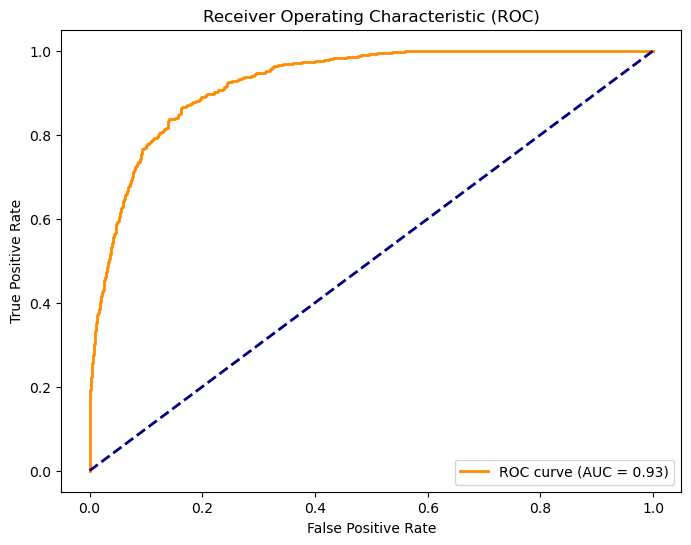

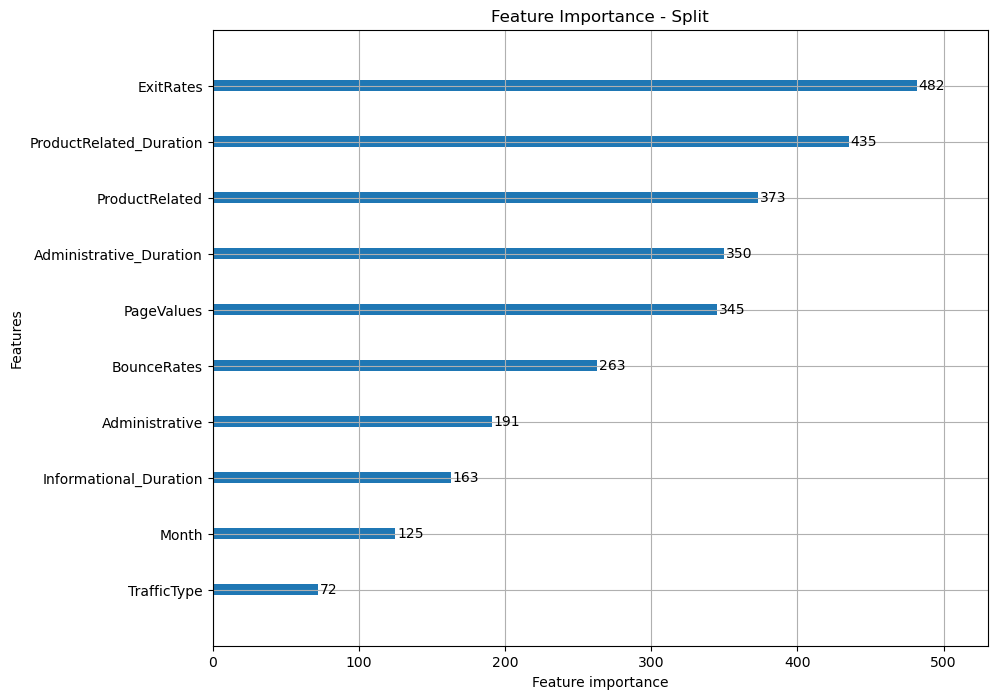

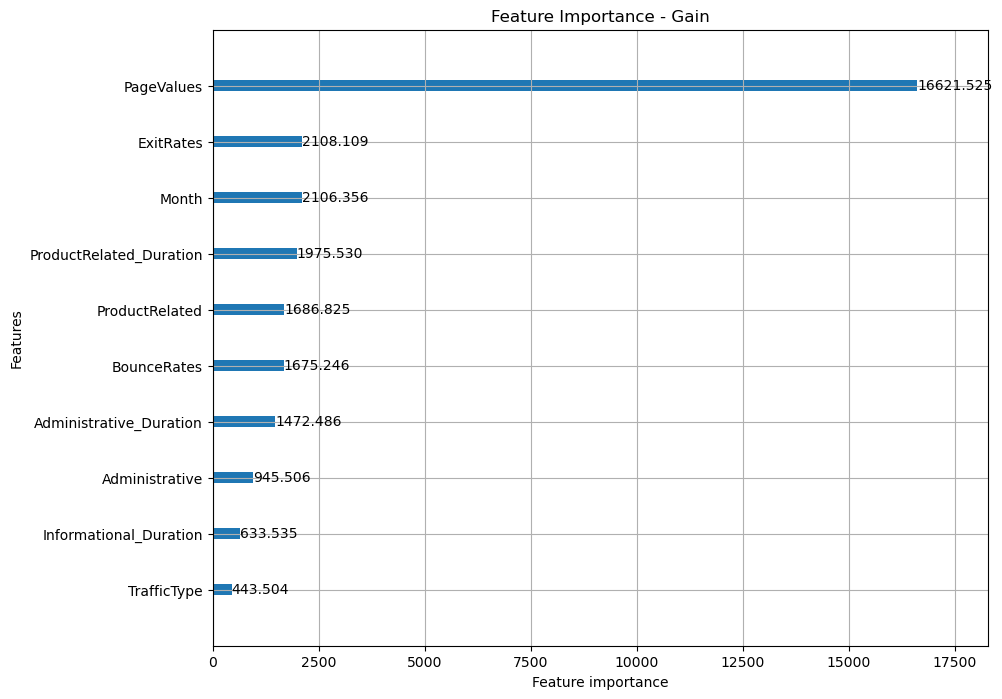

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Plot feature importance
lgb.plot_importance(model, figsize=(10, 8), max_num_features=10, importance_type='split')
plt.title('Feature Importance - Split')
plt.show()

lgb.plot_importance(model, figsize=(10, 8), max_num_features=10, importance_type='gain')
plt.title('Feature Importance - Gain')
plt.show()


# Training the model - II

`lightgbm` makes it easy to test on the unseen data at each iteration. Just add the `lgb_test` object to `valid_sets`.

How does the loss on the unseen data compare?

In [13]:
model = lgb.train(params=params,
                  train_set=lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  valid_names=['seen', '\tunseen']
                  
                 )

# Your thoughts below...


TypeError: train() got an unexpected keyword argument 'verbose'

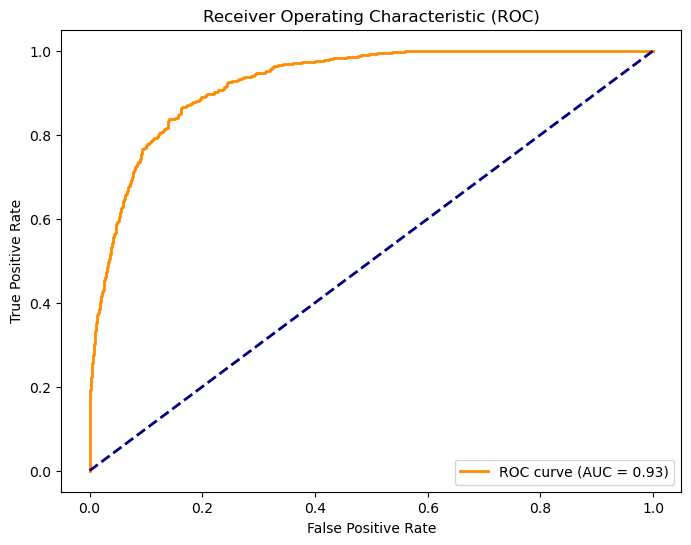

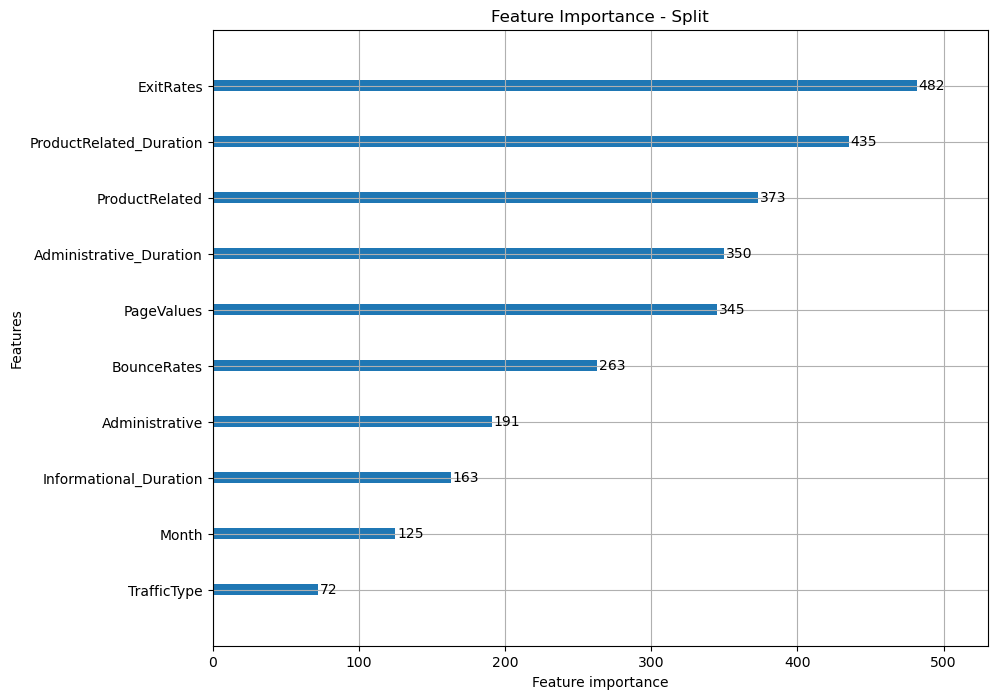

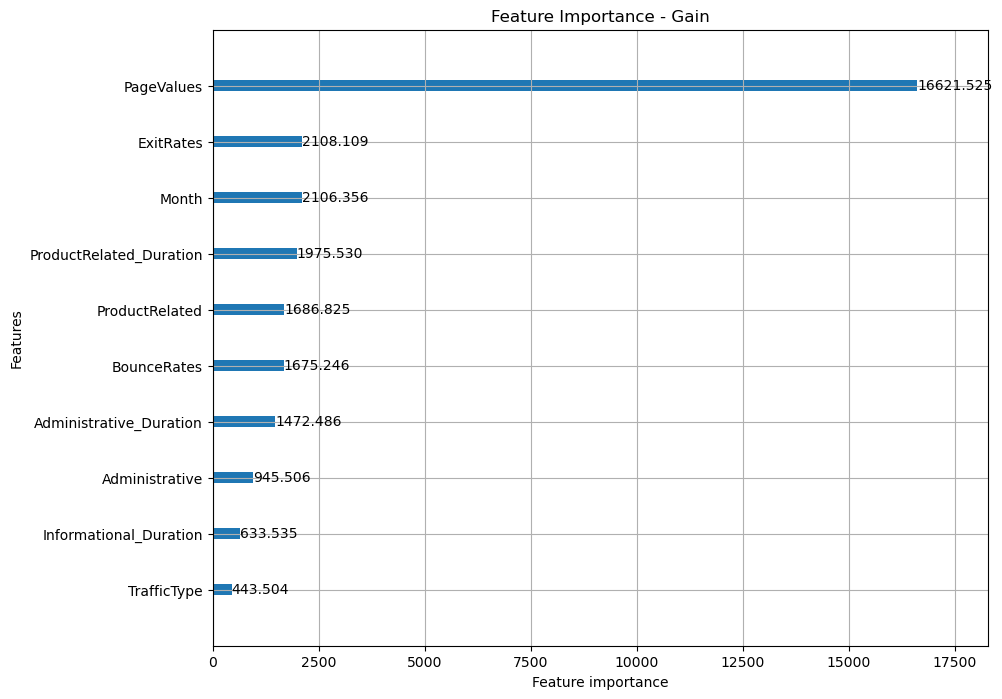

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Plot feature importance
lgb.plot_importance(model, figsize=(10, 8), max_num_features=10, importance_type='split')
plt.title('Feature Importance - Split')
plt.show()

lgb.plot_importance(model, figsize=(10, 8), max_num_features=10, importance_type='gain')
plt.title('Feature Importance - Gain')
plt.show()

# Training the model - III

Above we only used a measure of loss to evaluate the model. In classification tasks, we normally want to know the accuracy too.

Update `params` so that `metric` is a list that also includes `"auc"` and `"average_precision"`.

Run the model for 200 iterations by changing the value of `num_boost_round` when calling `lgb.train()`. Also, set `evals_result=metrics` - this will store the results of the training, for us to look at later on.

What do you observe this time?

In [11]:
# A dictionary to store the training results...
metrics = {}

# Your code and thoughts below...
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc', 'average_precision'],
    'num_leaves': 31,
    'learning_rate': 0.1,
    'max_depth':-1,
    'verbose': 0,
    'seed': 0,
}

model = lgb.train(params=params,
                  train_set=lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  valid_names=['seen', '\tunseen'],
                  num_boost_round=200,
                  evals_result=metrics
                 )
print('='*150)
print('Doubling the number of boosting rounds results in very low loss and very high metric scores for AUC/AP. It is very likely the model has overfitted to the training set!')



TypeError: train() got an unexpected keyword argument 'evals_result'

# Training the model - IV

Run the cell below to plot the data you stored in `metrics`. It loops through the individual metrics and plots them at each iteration.

What do you observe?

ValueError: eval results cannot be empty.

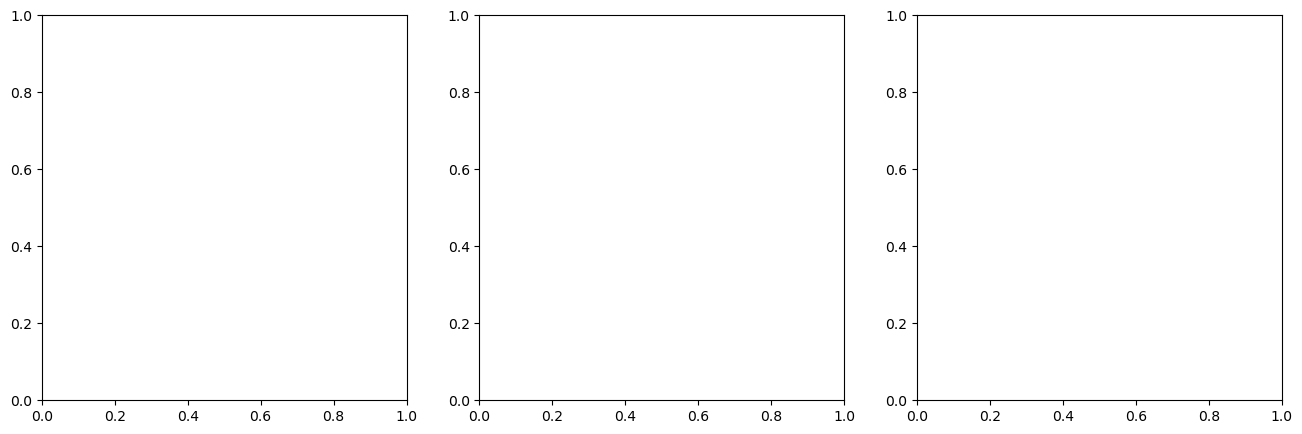

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

f, a = plt.subplots(1,3, figsize=(16,5))

for e, m in enumerate(['binary_logloss', 'auc', 'average_precision']):
    lgb.plot_metric(metrics, metric=m, ax=a[e], title=f"{m} during training")
    
    
plt.tight_layout()
# Your thoughts below...


# Investigating feature performance

`lightgbm` has built-in methods for seeing which features were most predictive.

There are two ways of measuring feature importance: 

* `split`: how many times a feature is used to make a decision in all the trees in the ensemble, except for leaf nodes. A feature which is used often to make decisions along the way is likely very informative.
* `gain`: the sum of the information gain score from using a feature in a tree.

These will each be normalised by the number of trees in the ensemble.

A trained `lightgbm` model has a very handy `.plot_importance()` method. Before running the cells below, what do you predict the most/least useful features will be when trying to predict whether a visitor to a website will make a purchase?

In [ ]:
for imp_type in ['split', 'gain']:
    ax = lgb.plot_importance(model,
                             importance_type=imp_type,
                             dpi=100,
                             title=f"Feature importance by {imp_type}"
                             )
# Your thoughts below...


# Getting predictions for new data

So far we have used only the data available, but in practice it is likely that more data will come in and you will want to evaluate that.

In `lightgbm` you can save/load trained models and continue training them, if you have more labeled data.

If you want predictions for unlabelled data, you can do that too. You can pass a DataFrame of just the `X` values.

The model's `.predict()` method will return a score for each item. If it is >= 0.5 then it is in the positive class, otherwise the negative.

The two examples below would be classified as leading to a sale.

In [ ]:
new_data_points = [
    [2.7, 99, 0.2, 30.0, 60, 12445.0, 0.0, 0.0, 20.5, 0.8, 'Feb', 1, 3, 2, 2, 'Returning_Visitor', True],
    [1.2, 99, 0.2, 1.0, 20, 942.0, 0.0, 0.0, 1.5, 0.28, 'Mar', 1, 1, 1, 1, 'Returning_Visitor', False],
]

new_data_points = pd.DataFrame(new_data_points, columns=data.columns[0:-1])

new_data_points[['Month', 'VisitorType', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']] = new_data_points[['Month', 'VisitorType', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']].astype('category')

model.predict(new_data_points)

# Finding the best model hyperparameters

As we saw, there are many hyperparameters to be tweaked - see [the documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) for more details.

One method is to try each combination manually, but this is time-consuming.

Instead, `lightgbm` can be used with `sklearn`'s  cross-validation methods. It will train multiple models on subsets of the data (and evaluate on the unseen remainder) for each combination of parameters and find the best combination.

The model we trained had around 75% accuracy in the best case. `lightgbm` makes the following suggestions for improving accuracy:

* Use large `max_bin` (may be slower)
* Use small `learning_rate` with large `n_estimators`
* Use large `num_leaves` (may cause over-fitting)
* Try `dart` rather than `gbdt` for the boosting method

We can try a few of these and some others.

The `GridSearchCV` class from `sklearn` takes a model, with a dictionary of hyperparameter and values. Then you just fit/train it as usual, using the training dataset we created at the beginning, `X_train` and `y_train`.

We use `lgb.LGBMClassifier()` as our model here, we assign it to the variable `classifier`.

Below, create a `GridSearchCV` in the same way you would an `sklearn` model: assign it to a variable named `gcv`, pass it the `classifier` as your basic model without parameters set, and also pass it `params`.

To speed things up, set `n_jobs=-1` to use all available CPU cores. Set `verbose=1` so you get updates as it proceeds - useful for making sure it is actually working!

This is around 480 models, which should take approximately 2 minutes on a four core machine. If it is going too slowly for you, try trimming a few of the items from each of the params. Alternatively you can include a wider range of items by uncommenting some of the values below, this will take longer but will result in a higher accuracy. Remember you can interrupt and restart the kernel if it is taking too long.

In [ ]:
from sklearn.model_selection import GridSearchCV

params = dict(
    max_bin=[155, 255],#,355,455],
    learning_rate=[0.001, 0.01],# 0.05, 0.1],
    n_estimators=[20, 50],# 80, 100, 120, 150, 200],
    num_leaves=[10, 20],#30, 40, 50],
    boosting=['dart', 'gbdt'],
    max_depth=[-1, 1, 2],#, 3, 4, 5],    
    seed=[0],        
)


classifier = lgb.LGBMClassifier()

# Your code below...


# What was the best model?

`GridSearchCV` evaluated each possible model using the accuracy metric.

The best model is stored inside `gcv` as `best_estimator_`. Its score is in `gcv.best_score_` and the actual hyperparameters used are in `gcv.best_params_`.

(The score here is not the score on the training set, but the average score across subsets of the training set.)

Take a look at these and then evaluate the best model on the test set `X_test` and `y_test` - the model in `gcv.best_estimator_` has a `.score()` method you can use.

How does it compare to the model you trained before?

In [ ]:
# Your code and thoughts below...


# A closer look at the best model - I

The feature importances can be found in the `.feature_importances_` attribute of the model - check the `.best_model.importance_type` attribute to see if the model used `split` or `gain` for importances.

The feature names are stored in `.feature_name_`.

Create a DataFrame from the two lists (importances and names) and see which features are most important for this model.

Have they changed with these new hyperparameters?

In [ ]:
best_model.importance_type

In [ ]:
# Your code and thoughts below...


# A closer look at the best model - II

We used accuracy so far to evaluate performance, but it would be better to know the per-class performance.

Get the best model's predictions for `X_test` using its `.predict()` method.

Then, compare these to the true `y_test` classes using `sklearn.metrics.classification_report`.

What do you observe?

In [ ]:
from sklearn.metrics import classification_report

# Your code and thoughts below...


# Conclusion and next steps

In this practical we went through the process of using `lightgbm` to classify customers, based on their behaviour on a website.

We trained and evaluated a single model before fine-tuning the hyperparameters to increase performance by a large margin.

We focused on classification but `lightgbm` also does regression. To take this practical further, you could try applying what you have learned to a regression dataset - see [the UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets.php) for possible datasets.

Look into the `lgb.LGBMRegressor()` class, which is an `sklearn`-style class. Or use the `lgb.train()` method and change the `params` dictionary so that `objective` and `metric` are suitable for regression.

Another thing to bear in mind is that `lightgbm` is very fast - we trained over 33k models on around 10k items in around 6 minutes. Try it on some big datasets.